#Майнор ИАД. Домашнее задание 3. YOLO.

Выборка, на котрой мы будем обучать модель. состоит из разнообразных фотографий яблок, бананов и апельсинов. [Ссылка на данные](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

In [ ]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачаем данные.

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 16
drwx------ 4 root root 4096 Dec 14 02:12 data
drwxr-xr-x 4 root root 4096 Dec 14 02:02 lightning_logs
drwxr-xr-x 3 root root 4096 Dec 14 02:12 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 12 14:35 sample_data


Посмотрим, как выглядит один из файлов разметки.

In [ ]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Реализация выборки.

In [ ]:
import os
import cv2
import json
import glob
import tqdm
import copy
import random
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

Для аугментаций будем пользоваться библиотекой albumentations [(документация)](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса.

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml")))
        
        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.get_boxes_from_xml(idx)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            class_labels = transformed['class_labels']
        return image / 255.0, (boxes, class_labels)

    def __len__(self):
        return len(self.image_paths)

    def get_boxes_from_xml(self, idx: int):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        with open(self.box_paths[idx]) as fd:
            doc = xmltodict.parse(fd.read())
        objects = doc['annotation']['object']

        with Image.open(self.image_paths[idx]) as img:
            im_w, im_h = img.size
        if type(objects) == dict:
            objects = [objects]
        for obj in objects:
            coords = obj['bndbox']
            box = [int(coords['xmin']), int(coords['ymin']), int(coords['xmax']), int(coords['ymax'])]
            class_labels.append(obj['name'])
            boxes.append(self.__convert_to_yolo_box_params(box, im_w, im_h))

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
        
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

In [ ]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([A.RandomSizedBBoxSafeCrop(height=HEIGHT, width=WIDTH),
                             A.HorizontalFlip(p=0.5),
                             A.RandomRotate90(p=0.5),
                             A.RandomBrightnessContrast(p=0.4),
                             A.GaussNoise(var_limit=350.0, p=0.4),
                             A.pytorch.transforms.ToTensorV2()], 
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(height=HEIGHT, width=WIDTH),
                            A.pytorch.transforms.ToTensorV2()], 
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [ ]:
seed_everything(123456)

train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )
# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
assert isinstance(train_dataset[0][1], tuple)
assert len(train_dataset[0][1]) == 2
print("Тесты успешно пройдены")

Тесты успешно пройдены


Напишем класс NewFruitDataset: он отличается от класса FruitDataset только тем, что у него метод \__getitem__ возвращает уже не просто список боксов с лейблами, а тензор размера S x S x (C + 5 * B).

S x S - это размер решетки;

(C + 5 * B): первые С элементов отведены под C классов (если объект относится к классу с номером 2, то элемент с индексом 2 будет единицей, а элементы с индексами 0 и 1 - нулями); оставшиеся 5 * B элементов отведены под B bounding box'ов. В каждом из B bounding box'ов есть x_center_relative_to_cell, y_center_relative_to_cell, width, height и 1 (1 - это индикатор того, что в данной ячейке решетки есть центр объекта.) У ячеек, не ответственных ни за один объект, все S x S x (C + 5 * B) элементов занулены.

Опираюсь на визуализацию и описание target переменной для YOLOv1:

https://wikidocs.net/167699

In [ ]:
class NewFruitDataset(FruitDataset):
    def __init__(self, S, B, C, data_dir, transforms=None):
        super().__init__(data_dir, transforms)
        self.S = S
        self.B = B
        self.C = C

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = super().get_boxes_from_xml(idx)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            class_labels = transformed['class_labels']

        grid = torch.zeros(self.S, self.S, self.B * 5 + self.C)

        for i in range(len(boxes)):
            x_center, y_center, width, height = boxes[i]
            class_number = class2tag[class_labels[i]] - 1
            # определяем координаты ячейки, ответственной за текущий объект
            x_in_grid = int(self.S * x_center)
            y_in_grid = int(self.S * y_center)
            # The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell. 
            x_center_relative_to_cell = self.S * x_center - x_in_grid
            y_center_relative_to_cell = self.S * y_center - y_in_grid
            # The width and height are predicted relative to the whole image. => width и height менять не нужно
            for j in range(self.B):
                grid[y_in_grid, x_in_grid, j * 5 + self.C : (j + 1) * 5 + self.C] = torch.Tensor([x_center_relative_to_cell, y_center_relative_to_cell, width, height, 1])
            grid[y_in_grid, x_in_grid, class_number] = 1
        
        # нормализуем картинку, чтобы все элементы тензора были в пределах от 0 до 1
        return image / 255.0, grid

In [ ]:
train_dataset = NewFruitDataset(
    S=7, B=2, C=3,
    transforms=train_transform,
    data_dir="./data/train"
    )
val_dataset = NewFruitDataset(
    S=7, B=2, C=3,
    transforms=test_transform, 
    data_dir="./data/test"
    )

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False,
    )

##Переводим боксы из yolo формата обратно

Пишем функцию, которая будет переводить [x_center_relative_to_cell, y_center_relative_to_cell, width, height] обратно в [x_min, y_min, x_max, y_max], чтобы визуализировать bounding box'ы. Так как x_center_relative_to_cell и y_center_relative_to_cell были посчитаны относительно размера ячейки решетки, в функцию подаются координаты этой самой ячейки (x_in_grid, y_in_grid)

In [ ]:
def yolo_to_original(box, x_in_grid, y_in_grid, S):
    x_center_relative_to_cell, y_center_relative_to_cell, width, height = box
    x_center = (x_center_relative_to_cell + x_in_grid) / S
    y_center = (y_center_relative_to_cell + y_in_grid) / S

    x_min = (x_center - width / 2) * WIDTH
    x_max = (x_center + width / 2) * WIDTH
    y_min = (y_center - height / 2) * HEIGHT
    y_max = (y_center + height / 2) * HEIGHT

    return torch.Tensor([x_min, y_min, x_max, y_max])

Протестируем функцию на каком-нибудь изображении из датасета.

In [ ]:
def draw_boxes(image):
    boxes = list()
    for y in range(7):
        for x in range(7):
            description = image[1][y][x]
            if description[-1] == 1:
              boxes.append((x, y, description[3:7]))
    shapes = list()
    for box in boxes:
        shapes.append(yolo_to_original(box[2], box[0], box[1], 7))
    transform = torchvision.transforms.ToPILImage()
    img = transform(image[0])
    # create rectangle image
    img1 = ImageDraw.Draw(img) 
    for shape in shapes:
        print(shape)
        img1.rectangle(list(shape), outline ="white")
    return img

tensor([101.2553,  75.7603, 221.4504, 192.0852])
tensor([216.3512,  72.7776, 356.9431, 205.8056])
tensor([  0.0000, 202.8229, 396.2797, 353.7470])


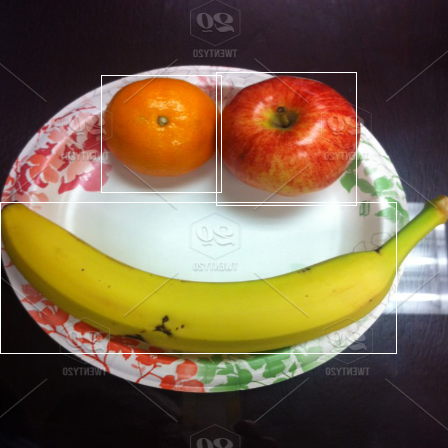

In [ ]:
seed_everything(123456)

draw_boxes(train_dataset[162])

всё правильно!

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников.

In [ ]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """

    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / (union_area + 1e-6) # чтобы на ноль не делить
    return iou

Один из источников (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLO/utils.py) предлагает подавать в функцию intersection_over_union сразу целый батч, а не только два прямоугольника, я попытаюсь сделать аналогично (чтобы не ходить циклом по батчу и потом еще двойным циклом по ячейкам во время вычисления лосса, а делать операции с тензорами, что гораздо быстрее)

In [ ]:
def intersection_over_union_for_batches(predicted_bbox, gt_bbox) -> float:
    """
    :param: predicted_bbox - тензор размера batch_size x S x S x 4; прямоугольник - [x_center_relative_to_cell, y_center_relative_to_cell, width, height]
    :param: gt_bbox - тензор размера batch_size x S x S x 4; прямоугольник - [x_center_relative_to_cell, y_center_relative_to_cell, width, height]
    :return: Intersection Over Union
    """
    
    predicted_bbox = [predicted_bbox[..., 0:1] - predicted_bbox[..., 2:3] / 2, 
                      predicted_bbox[..., 1:2] - predicted_bbox[..., 3:4] / 2,
                      predicted_bbox[..., 0:1] + predicted_bbox[..., 2:3] / 2,
                      predicted_bbox[..., 1:2] + predicted_bbox[..., 3:4] / 2]
    gt_bbox = [gt_bbox[..., 0:1] - gt_bbox[..., 2:3] / 2,
              gt_bbox[..., 1:2] - gt_bbox[..., 3:4] / 2,
              gt_bbox[..., 0:1] + gt_bbox[..., 2:3] / 2,
              gt_bbox[..., 1:2] + gt_bbox[..., 3:4] / 2]

    intersection_bbox = [
            torch.max(predicted_bbox[0], gt_bbox[0]),
            torch.max(predicted_bbox[1], gt_bbox[1]),
            torch.min(predicted_bbox[2], gt_bbox[2]),
            torch.min(predicted_bbox[3], gt_bbox[3]),
        ]

    intersection_area = (intersection_bbox[2] - intersection_bbox[0]).clamp(0) * (intersection_bbox[3] - intersection_bbox[1]).clamp(0)

    area_predicted = abs((predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1]))
    area_gt = abs((gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1]))

    union_area = area_predicted + area_gt - intersection_area
    iou = intersection_area / (union_area + 1e-6) # чтобы на ноль не делить
    return iou

[Оригинальная статья, в которой описана архитектура YOLOv1.](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)

## Реализация модели

Выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек, на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробок и один класс.

In [ ]:
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, is_max_pool:bool=False):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, dropout, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()
        self.dropout = dropout
        self.S = S
        self.B = B
        self.C = C

        # модель как в статье, добавляем паддинг в зависимости от kernel_size, иначе от картинки ничего не останется
        self.model = nn.Sequential(
            CNNBlock(3, 64, 7, padding=3, stride=2, is_max_pool=True),
            CNNBlock(64, 192, 3, padding=1, is_max_pool=True),
            CNNBlock(192, 128, 1),
            CNNBlock(128, 256, 3, padding=1),
            CNNBlock(256, 256, 1),
            CNNBlock(256, 512, 3, padding=1, is_max_pool=True),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 1024, 3, padding=1, is_max_pool=True),
            CNNBlock(1024, 512, 1),
            CNNBlock(512, 1024, 3, padding=1),
            CNNBlock(1024, 512, 1),
            CNNBlock(512, 1024, 3, padding=1),
            CNNBlock(1024, 1024, 3, padding=1),
            CNNBlock(1024, 1024, 3, padding=1, stride=2),
            CNNBlock(1024, 1024, 3, padding=1),
            CNNBlock(1024, 1024, 3, padding=1)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.S * self.S * 1024, 512),
            nn.Dropout(self.dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(512, self.S * self.S * (5 * self.B + self.C))
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc_block(x)
        x = x.reshape(-1, self.S, self.S, self.B * 5 + self.C)
        return x

# подаем на вход целый батч, потому что батчнорм выдает ошибку, если закидывать в модель только один объект
batch_size = 4
temp_model = YOLO(dropout=0)
# размер получившегося тензора - размер одного объекта, домноженный на batch_size
expected_output_shape = batch_size * temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)
for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    outputs = temp_model(inputs)
    break
assert outputs.reshape(-1).shape[0] == expected_output_shape
assert labels.reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

Опираюсь на объяснение YoloLoss из этой статьи:

https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        
        # CLASSIFICATION LOSS

        classification_loss = self.mse(target[..., 0 : self.C] * target[..., self.C + 4 : self.C + 5], 
                                       predictions[..., 0 : self.C] * target[..., self.C + 4 : self.C + 5])
        
        # LOCALIZATION LOSS

        # выбираем бокс, у которого самый высокий IOU с боксом таргета
        batch_size = target.size()[0]
        ious_1 = intersection_over_union_for_batches(predictions[..., self.C : self.C + 4], target[..., self.C : self.C + 4]).unsqueeze(0)
        ious_2 = intersection_over_union_for_batches(predictions[..., self.C + 5 : self.C + 9], target[..., self.C : self.C + 4]).unsqueeze(0)
        ious = torch.cat([ious_1, ious_2], dim=0)
        _, ious_max = torch.max(ious, dim=0)
        chosen_boxes = (1 - ious_max) * predictions[..., self.C : self.C + 5] + ious_max * predictions[..., self.C + 5 : self.C + 10]
        x_predictions = chosen_boxes[..., 0:1]
        y_predictions = chosen_boxes[..., 1:2]
        # чтобы отрицательное число под корень не поставить:
        sqrt_w_predictions = torch.sign(chosen_boxes[..., 2:3]) * torch.sqrt(torch.abs(chosen_boxes[..., 2:3]))
        sqrt_h_predictions = torch.sign(chosen_boxes[..., 3:4]) * torch.sqrt(torch.abs(chosen_boxes[..., 3:4]))

        x_target = target[..., self.C : self.C + 1]
        y_target = target[..., self.C + 1 : self.C + 2]
        sqrt_w_target = torch.sqrt(target[..., self.C + 2 : self.C + 3])
        sqrt_h_target = torch.sqrt(target[..., self.C + 3 : self.C + 4])
        x_loss = self.mse(x_target * target[..., self.C + 4 : self.C + 5], 
                     x_predictions * target[..., self.C + 4 : self.C + 5])
        y_loss = self.mse(y_target * target[..., self.C + 4 : self.C + 5], 
                     y_predictions * target[..., self.C + 4 : self.C + 5])
        w_loss = self.mse(sqrt_w_target * target[..., self.C + 4 : self.C + 5], 
                     sqrt_w_predictions * target[..., self.C + 4 : self.C + 5])
        h_loss = self.mse(sqrt_h_target * target[..., self.C + 4 : self.C + 5], 
                     sqrt_h_predictions * target[..., self.C + 4 : self.C + 5])
        localization_loss = x_loss + y_loss + w_loss + h_loss

        # CONFIDENCE LOSS

        # только для тех боксов, где есть объект и которые ответственны за этот объект:
        confidence_loss_obj = self.mse(chosen_boxes[..., 4:5] * target[..., self.C + 4 : self.C + 5], 
                                      target[..., self.C + 4 : self.C + 5])
        # для всех остальных боксов:
        confidence_loss_noobj = 0
        
        for i in range(self.B):
            confidence_loss_noobj += self.mse(predictions[..., self.C + (i + 1) * 5 - 1 : self.C + (i + 1) * 5] * 
                                      (1 - target[..., self.C + 4 : self.C + 5]), 
                                      target[..., self.C + (i + 1) * 5 - 1 : self.C + (i + 1) * 5] * 
                                      (1 - target[..., self.C + 4 : self.C + 5]))

        return self.lambda_coord * localization_loss + confidence_loss_obj + self.lambda_noobj * confidence_loss_noobj + classification_loss

## Реализуйте дополнительные функции из статьи - 2 балла

Функция, которая переводит боксы из yolo формата в оригинальный, оказалась неудобной - она только для одного объекта, тогда как перед non-maximum suppression в оригинальный формат нужно перевести ВСЕ боксы. Перепишем функцию: в нее будет подаваться двумерный тензор размером S*S x 5, состоящий из боксов (у каждого бокса x, y, w, h, c). Выскакивающие за пределы отрезка [0; 447] значения x_min, y_min, x_max и y_max (такое может получаться на валидации) загоняем в границы.

In [ ]:
def yolo_to_original_for_whole_image(box, S):
    grid_indices = torch.Tensor(S, S, 2).to(device)
    for i in range(S):
        for j in range(S):
            grid_indices[i][j][0] = j
            grid_indices[i][j][1] = i
    grid_indices = grid_indices.reshape(S * S, 2)
    x_in_grid = grid_indices[..., 0:1]
    y_in_grid = grid_indices[..., 1:2]

    x_center_relative_to_cell = box[..., 0:1]
    y_center_relative_to_cell = box[..., 1:2]
    width = box[..., 2:3]
    height = box[..., 3:4]
    x_center = (x_center_relative_to_cell + x_in_grid) / S
    y_center = (y_center_relative_to_cell + y_in_grid) / S

    x_min = (x_center - width / 2) * WIDTH
    x_min[x_min < 0] = 0

    x_max = (x_center + width / 2) * WIDTH
    x_max[x_max > WIDTH - 1] = WIDTH - 1

    y_min = (y_center - height / 2) * HEIGHT
    y_min[y_min < 0] = 0

    y_max = (y_center + height / 2) * HEIGHT
    y_max[y_max > HEIGHT - 1] = HEIGHT - 1

    return torch.cat((x_min, y_min, x_max, y_max, box[..., 4:5]), 1)

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False,
    )

Опираюсь на описание non-maximum suppression:

https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    # на вход функции подается двумерный тензор размера S*S x 6: 
    # это S*S боксов, у каждого бокса x_min, y_min, x_max, y_max, confidence и номер класса

    # убираем все боксы, у которых confidence меньше threshold
    bboxes = bboxes[bboxes[:, 4] >= threshold]
    len(bboxes)
    bboxes = sorted(bboxes, key=lambda x:x[4], reverse=True)
    boxes_after_nms = []

    # на каждом шаге берем бокс с наибольшим confidence и убираем все те, 
    # у которых с ним одинаковый класс и IOU больше, чем iou_threshold
    while bboxes:
        current_box = bboxes[0]
        bboxes.pop(0)
        boxes_after_nms.append(current_box)
        bboxes = [bbox for bbox in bboxes if bbox[5] != current_box[5] 
                  or intersection_over_union(bbox, current_box) <= iou_threshold]

    return boxes_after_nms

In [ ]:
train_dataloader_for_get_boxes = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    )
val_dataloader_for_get_boxes = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    )

Функция get_bound_boxes нужна, чтобы после каждой эпохи достать все bounding box'ы, применить к ним non-maximum suppression и потом посчитать для них mAP.

In [ ]:
def get_bound_boxes(loader, model, S, B, C, iou_threshold=.5, threshold=.4):
    model = model.to(device)
    model.eval()
    all_pred_boxes = []
    all_true_boxes = []
    for batch, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device) 

        with torch.no_grad():
            predictions_batch = model(inputs)

        batch_size = labels.size()[0]
        for i in range(batch_size):
            # берем картинку из батча

            ground_truth = labels[i]
            predictions = predictions_batch[i]
            # достаем true_boxes - это все боксы в target, у которых confidence = 1

            true_boxes = yolo_to_original_for_whole_image(ground_truth[..., C : C + 5].reshape(S * S, 5), S).to(device)
            true_classes = torch.argmax(ground_truth[..., 0 : C].reshape(S * S, C), dim=1).unsqueeze(-1)
            true_boxes_with_classes = torch.cat((true_boxes, true_classes), 1)
            true_boxes_with_classes = true_boxes_with_classes[true_boxes_with_classes[:, 4] == 1]
            all_true_boxes.append(list(true_boxes_with_classes.cpu()))

            # теперь достаем prediction_boxes
            confidences = torch.Tensor(S, S, B).to(device)
            boxes = []
            # для каждой ячейки выбираем один бокс, у которого больше confidence 
            for i in range(B):
                confidences[..., i : i + 1] = predictions[..., C - 1 + (i + 1) * 5 : C + (i + 1) * 5]
                boxes.append(predictions[..., i * 5 + C : (i + 1) * 5 + C])
            confidence_tensor = nn.functional.one_hot(torch.argmax(confidences, dim=-1), num_classes = B)
            chosen_boxes = yolo_to_original_for_whole_image((torch.stack(boxes, dim=2) * confidence_tensor.unsqueeze(dim=3)).sum(2).reshape(S * S, 5), S)
            predictions_classes = torch.argmax(predictions[..., 0 : C].reshape(S * S, C), dim=1).unsqueeze(-1)
            predictions_boxes_with_classes = torch.cat((chosen_boxes, predictions_classes), 1)

            # и подаем эти боксы функции non_max_suppression
            predictions_boxes_after_nms = non_max_suppression(predictions_boxes_with_classes.cpu(), iou_threshold, threshold)
            all_pred_boxes.append(predictions_boxes_after_nms)

    model.train()
    return all_pred_boxes, all_true_boxes

Опираюсь на описание mean average precision:

https://towardsdatascience.com/implementation-of-mean-average-precision-map-with-non-maximum-suppression-f9311eb92522

AUC-PR для каждого класса считаю с помощью функции trapezoid: 

https://pytorch.org/docs/stable/generated/torch.trapezoid.html

In [ ]:
def mean_average_precision(pred_boxes, true_boxes_intact, C, iou_threshold=0.5):
    ground_truths_per_class = [0] * C
    average_precisions = [0] * C
    for image in true_boxes_intact:
        for box in image:
            ground_truths_per_class[int(box[5])] += 1

    true_boxes = copy.deepcopy(true_boxes_intact)
    num_objects = len(pred_boxes)
    box_tensor = []
    for i in range(num_objects):
        current_pred_boxes = pred_boxes[i]
        current_true_boxes = true_boxes[i]
        for box in current_pred_boxes:
            true_box_idx = -1
            best_iou = 0
            true_positive = 0
            for j in range(len(current_true_boxes)):
                if box[5] == current_true_boxes[j][5]:
                    iou = intersection_over_union(box, current_true_boxes[j])
                    if iou > best_iou:
                        true_box_idx = j
                        best_iou = iou
            if best_iou > iou_threshold:
                current_true_boxes.pop(true_box_idx)
                true_positive = 1
            box_tensor.append(torch.Tensor([box[4], true_positive, box[5]]))
    box_tensor.sort(key=lambda x: x[0], reverse=True)
    
    if box_tensor:
        box_tensor = torch.stack(box_tensor, dim=0)
        classes_tensors = []
        
        for i in range(C):
            class_tensor = box_tensor[box_tensor[:, 2] == i]
            num_ground_truths = ground_truths_per_class[i]
            num_predictions = class_tensor.size()[0]
            if num_ground_truths == 0 or num_predictions == 0:
                average_precisions[i] = 0
            else:
                cumulative_false_positives = torch.cumsum(1 - class_tensor[..., 1:2], dim=0)
                cumulative_true_positives = torch.cumsum(class_tensor[..., 1:2], dim=0)
                recall_curve = torch.cat((torch.Tensor([0.]), 
                                          (cumulative_true_positives / num_ground_truths).squeeze(1)))
                precision_curve = torch.cat((torch.Tensor([1.]), 
                                            (cumulative_true_positives / (cumulative_true_positives + cumulative_false_positives)).squeeze(1)))
                average_precisions[i] = torch.trapezoid(precision_curve, recall_curve)
        
        return (sum(average_precisions) / len(average_precisions)).item()

    else:
        return 0

## Обучение модели, подсчет метрик

Буду считать средний yololoss на объекте (не на батче, потому что объектов мало) и mAP параллельно для обучающей и валидационной выборки.

В идеале лосс на объекте должен быть не выше 1: https://stackoverflow.com/questions/51073671/whats-a-good-value-for-the-loss-function-of-a-dl-model-like-yolo

Если убрать dropout и все аугментации, то получается подогнать модель под тестовую выборку почти полностью, а mAP на тесте где-то после ста эпох получается 24%. Попробуем добить mAP на тесте хотя бы до 40-50%: запускаем обучение модели и оставляем на 300 эпох.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
BATCH_SIZE = 16
S = 7
B = 2
C = 3

In [ ]:
TRAIN_OBJECTS = len(train_dataset)
VAL_OBJECTS = len(val_dataset)

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    )

In [ ]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model, optimizer) -> None:
        super().__init__()

        self.model = model.to(device)
        self.loss = YoloLoss()
        self.optimizer = optimizer

    def forward(self, x) -> torch.Tensor:
        return self.model(x.to(device))

    def configure_optimizers(self):
            return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        loss = self.loss(self.model(images.to(device)), target)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        loss = self.loss(self.model(images.to(device)), target)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def training_epoch_end(self, outputs) -> None:
        all_pred_boxes, all_true_boxes = get_bound_boxes(train_dataloader_for_get_boxes, self.model, S, B, C)
        loss = (sum(output['loss'] for output in outputs) / TRAIN_OBJECTS).item()
        print("Train epoch:", self.current_epoch)
        print("Train average loss per object:", loss)
        print("Train mAP:", mean_average_precision(all_pred_boxes, all_true_boxes, C))
        print("----------------------------")

    def validation_epoch_end(self, outputs) -> None:
        all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader_for_get_boxes, self.model, S, B, C)
        loss = (sum(outputs) / VAL_OBJECTS).item()
        print("Vaidation epoch:", self.current_epoch)
        print("Validation average loss per object:", loss)
        print("Validation mAP:", mean_average_precision(all_pred_boxes, all_true_boxes, C))
        print("----------------------------")

In [ ]:
seed_everything(123456)

model = YOLO(dropout=0.1).to(device)
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
yolo_learner = YOLOLearner(model=model, optimizer=optimizer)
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 86.2 M
1 | loss  | YoloLoss | 0     
-----------------------------------
86.2 M    Trainable params
0         Non-trainable params
86.2 M    Total params
344.799   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Vaidation epoch: 0
Validation average loss per object: 9.35184383392334
Validation mAP: 0
----------------------------


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 0
Validation average loss per object: 7.225457191467285
Validation mAP: 0.07335178554058075
----------------------------
Train epoch: 0
Train average loss per object: 18.67369842529297
Train mAP: 0.03791731595993042
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 1
Validation average loss per object: 5.971354007720947
Validation mAP: 0.011481364257633686
----------------------------
Train epoch: 1
Train average loss per object: 9.467400550842285
Train mAP: 0.017738549038767815
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 2
Validation average loss per object: 5.6028265953063965
Validation mAP: 0.017012495547533035
----------------------------
Train epoch: 2
Train average loss per object: 7.968361854553223
Train mAP: 0.011278859339654446
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 3
Validation average loss per object: 7.043789863586426
Validation mAP: 0.010812290012836456
----------------------------
Train epoch: 3
Train average loss per object: 7.025824546813965
Train mAP: 0.030280856415629387
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 4
Validation average loss per object: 6.864562511444092
Validation mAP: 0.016790593042969704
----------------------------
Train epoch: 4
Train average loss per object: 7.013831615447998
Train mAP: 0.025214195251464844
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 5
Validation average loss per object: 5.6224164962768555
Validation mAP: 0.006841145921498537
----------------------------
Train epoch: 5
Train average loss per object: 6.146721363067627
Train mAP: 0.023161886259913445
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 6
Validation average loss per object: 6.0987348556518555
Validation mAP: 0.037959255278110504
----------------------------
Train epoch: 6
Train average loss per object: 6.065147399902344
Train mAP: 0.075507752597332
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 7
Validation average loss per object: 5.411580562591553
Validation mAP: 0.04055525362491608
----------------------------
Train epoch: 7
Train average loss per object: 5.847262382507324
Train mAP: 0.06986617296934128
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 8
Validation average loss per object: 6.189997673034668
Validation mAP: 0.003252471098676324
----------------------------
Train epoch: 8
Train average loss per object: 5.778985977172852
Train mAP: 0.004991679918020964
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 9
Validation average loss per object: 5.776629447937012
Validation mAP: 0.043619412928819656
----------------------------
Train epoch: 9
Train average loss per object: 5.564121723175049
Train mAP: 0.055865272879600525
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 10
Validation average loss per object: 6.443764686584473
Validation mAP: 0.0457964651286602
----------------------------
Train epoch: 10
Train average loss per object: 5.34043025970459
Train mAP: 0.035087138414382935
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 11
Validation average loss per object: 4.625809669494629
Validation mAP: 0.07323465496301651
----------------------------
Train epoch: 11
Train average loss per object: 5.631960868835449
Train mAP: 0.09362844377756119
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 12
Validation average loss per object: 5.288608074188232
Validation mAP: 0.049178000539541245
----------------------------
Train epoch: 12
Train average loss per object: 5.217442512512207
Train mAP: 0.061820417642593384
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 13
Validation average loss per object: 4.535407543182373
Validation mAP: 0.0856870785355568
----------------------------
Train epoch: 13
Train average loss per object: 5.121405124664307
Train mAP: 0.1372816562652588
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 14
Validation average loss per object: 6.623795032501221
Validation mAP: 0.02577645517885685
----------------------------
Train epoch: 14
Train average loss per object: 5.061609268188477
Train mAP: 0.028885776177048683
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 15
Validation average loss per object: 5.519651412963867
Validation mAP: 0.05226188525557518
----------------------------
Train epoch: 15
Train average loss per object: 5.295640468597412
Train mAP: 0.07440204918384552
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 16
Validation average loss per object: 4.737757205963135
Validation mAP: 0.11987780779600143
----------------------------
Train epoch: 16
Train average loss per object: 4.939550876617432
Train mAP: 0.12816281616687775
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 17
Validation average loss per object: 4.77872371673584
Validation mAP: 0.09442457556724548
----------------------------
Train epoch: 17
Train average loss per object: 4.81216287612915
Train mAP: 0.1469404250383377
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 18
Validation average loss per object: 4.667524337768555
Validation mAP: 0.11875484138727188
----------------------------
Train epoch: 18
Train average loss per object: 4.72577428817749
Train mAP: 0.16655512154102325
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 19
Validation average loss per object: 4.370969772338867
Validation mAP: 0.15946932137012482
----------------------------
Train epoch: 19
Train average loss per object: 4.681240558624268
Train mAP: 0.12850402295589447
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 20
Validation average loss per object: 4.143375396728516
Validation mAP: 0.16021275520324707
----------------------------
Train epoch: 20
Train average loss per object: 4.665266990661621
Train mAP: 0.1988760232925415
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 21
Validation average loss per object: 4.240497589111328
Validation mAP: 0.14445938169956207
----------------------------
Train epoch: 21
Train average loss per object: 4.499487400054932
Train mAP: 0.14688004553318024
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 22
Validation average loss per object: 4.0661163330078125
Validation mAP: 0.24062369763851166
----------------------------
Train epoch: 22
Train average loss per object: 4.4570207595825195
Train mAP: 0.24280506372451782
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 23
Validation average loss per object: 4.1256842613220215
Validation mAP: 0.2674180567264557
----------------------------
Train epoch: 23
Train average loss per object: 4.386221408843994
Train mAP: 0.2229776531457901
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 24
Validation average loss per object: 4.006147384643555
Validation mAP: 0.20126445591449738
----------------------------
Train epoch: 24
Train average loss per object: 4.1871795654296875
Train mAP: 0.21370764076709747
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 25
Validation average loss per object: 3.9744834899902344
Validation mAP: 0.20446474850177765
----------------------------
Train epoch: 25
Train average loss per object: 4.232797622680664
Train mAP: 0.2215825319290161
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 26
Validation average loss per object: 3.864091634750366
Validation mAP: 0.24431569874286652
----------------------------
Train epoch: 26
Train average loss per object: 4.276740550994873
Train mAP: 0.2866779565811157
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 27
Validation average loss per object: 3.879566192626953
Validation mAP: 0.23900990188121796
----------------------------
Train epoch: 27
Train average loss per object: 4.304965019226074
Train mAP: 0.1973739117383957
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 28
Validation average loss per object: 3.8399481773376465
Validation mAP: 0.21461214125156403
----------------------------
Train epoch: 28
Train average loss per object: 4.175176620483398
Train mAP: 0.22280271351337433
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 29
Validation average loss per object: 3.9198498725891113
Validation mAP: 0.18036596477031708
----------------------------
Train epoch: 29
Train average loss per object: 3.9983229637145996
Train mAP: 0.14233286678791046
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 30
Validation average loss per object: 3.7208328247070312
Validation mAP: 0.16439296305179596
----------------------------
Train epoch: 30
Train average loss per object: 4.039671421051025
Train mAP: 0.16877484321594238
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 31
Validation average loss per object: 3.762244462966919
Validation mAP: 0.21262617409229279
----------------------------
Train epoch: 31
Train average loss per object: 4.035675048828125
Train mAP: 0.1966136246919632
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 32
Validation average loss per object: 3.823786735534668
Validation mAP: 0.21030418574810028
----------------------------
Train epoch: 32
Train average loss per object: 3.8896126747131348
Train mAP: 0.24649526178836823
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 33
Validation average loss per object: 3.7294695377349854
Validation mAP: 0.2661024034023285
----------------------------
Train epoch: 33
Train average loss per object: 4.022736549377441
Train mAP: 0.20174609124660492
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 34
Validation average loss per object: 3.665499448776245
Validation mAP: 0.21767373383045197
----------------------------
Train epoch: 34
Train average loss per object: 3.8720741271972656
Train mAP: 0.24637436866760254
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 35
Validation average loss per object: 3.570807695388794
Validation mAP: 0.20439594984054565
----------------------------
Train epoch: 35
Train average loss per object: 3.85451602935791
Train mAP: 0.24975275993347168
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 36
Validation average loss per object: 3.53456449508667
Validation mAP: 0.22198830544948578
----------------------------
Train epoch: 36
Train average loss per object: 3.7966806888580322
Train mAP: 0.2914145290851593
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 37
Validation average loss per object: 3.5913233757019043
Validation mAP: 0.23556114733219147
----------------------------
Train epoch: 37
Train average loss per object: 3.8385672569274902
Train mAP: 0.24033810198307037
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 38
Validation average loss per object: 3.53198504447937
Validation mAP: 0.26528382301330566
----------------------------
Train epoch: 38
Train average loss per object: 3.74194073677063
Train mAP: 0.30726027488708496
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 39
Validation average loss per object: 3.413923740386963
Validation mAP: 0.26242777705192566
----------------------------
Train epoch: 39
Train average loss per object: 3.599813938140869
Train mAP: 0.3035888671875
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 40
Validation average loss per object: 3.3592443466186523
Validation mAP: 0.29094231128692627
----------------------------
Train epoch: 40
Train average loss per object: 3.5948002338409424
Train mAP: 0.24977970123291016
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 41
Validation average loss per object: 3.432109832763672
Validation mAP: 0.26163196563720703
----------------------------
Train epoch: 41
Train average loss per object: 3.626769781112671
Train mAP: 0.33156153559684753
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 42
Validation average loss per object: 3.3890841007232666
Validation mAP: 0.2140236645936966
----------------------------
Train epoch: 42
Train average loss per object: 3.6167290210723877
Train mAP: 0.23068177700042725
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 43
Validation average loss per object: 3.4557065963745117
Validation mAP: 0.24376285076141357
----------------------------
Train epoch: 43
Train average loss per object: 3.568620204925537
Train mAP: 0.259162575006485
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 44
Validation average loss per object: 3.465593099594116
Validation mAP: 0.2483171820640564
----------------------------
Train epoch: 44
Train average loss per object: 3.5512115955352783
Train mAP: 0.37060046195983887
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 45
Validation average loss per object: 3.420884132385254
Validation mAP: 0.20538455247879028
----------------------------
Train epoch: 45
Train average loss per object: 3.6079139709472656
Train mAP: 0.2707671523094177
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 46
Validation average loss per object: 3.6672818660736084
Validation mAP: 0.1761883646249771
----------------------------
Train epoch: 46
Train average loss per object: 3.7006800174713135
Train mAP: 0.2347666472196579
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 47
Validation average loss per object: 3.4107110500335693
Validation mAP: 0.2240048497915268
----------------------------
Train epoch: 47
Train average loss per object: 3.535644054412842
Train mAP: 0.26111117005348206
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 48
Validation average loss per object: 3.6932525634765625
Validation mAP: 0.12622936069965363
----------------------------
Train epoch: 48
Train average loss per object: 3.6972806453704834
Train mAP: 0.15107043087482452
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 49
Validation average loss per object: 3.5205698013305664
Validation mAP: 0.2145177721977234
----------------------------
Train epoch: 49
Train average loss per object: 3.6186842918395996
Train mAP: 0.2730090916156769
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 50
Validation average loss per object: 3.2514960765838623
Validation mAP: 0.2871862053871155
----------------------------
Train epoch: 50
Train average loss per object: 3.6286964416503906
Train mAP: 0.3597336709499359
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 51
Validation average loss per object: 3.435849666595459
Validation mAP: 0.26252591609954834
----------------------------
Train epoch: 51
Train average loss per object: 3.3856201171875
Train mAP: 0.337304025888443
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 52
Validation average loss per object: 4.018609046936035
Validation mAP: 0.11409121751785278
----------------------------
Train epoch: 52
Train average loss per object: 3.406278133392334
Train mAP: 0.2636009752750397
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 53
Validation average loss per object: 3.7807719707489014
Validation mAP: 0.25929394364356995
----------------------------
Train epoch: 53
Train average loss per object: 3.3192899227142334
Train mAP: 0.2953493297100067
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 54
Validation average loss per object: 3.6367127895355225
Validation mAP: 0.14974848926067352
----------------------------
Train epoch: 54
Train average loss per object: 3.4001684188842773
Train mAP: 0.30929526686668396
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 55
Validation average loss per object: 3.3791143894195557
Validation mAP: 0.23965515196323395
----------------------------
Train epoch: 55
Train average loss per object: 3.2157745361328125
Train mAP: 0.34084758162498474
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 56
Validation average loss per object: 3.8295176029205322
Validation mAP: 0.18533159792423248
----------------------------
Train epoch: 56
Train average loss per object: 3.3622541427612305
Train mAP: 0.2242581844329834
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 57
Validation average loss per object: 3.527225971221924
Validation mAP: 0.188870370388031
----------------------------
Train epoch: 57
Train average loss per object: 3.4150211811065674
Train mAP: 0.24041564762592316
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 58
Validation average loss per object: 3.5003058910369873
Validation mAP: 0.2390919178724289
----------------------------
Train epoch: 58
Train average loss per object: 3.3630566596984863
Train mAP: 0.30793920159339905
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 59
Validation average loss per object: 3.269144296646118
Validation mAP: 0.2476930469274521
----------------------------
Train epoch: 59
Train average loss per object: 3.2006165981292725
Train mAP: 0.4054443836212158
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 60
Validation average loss per object: 3.2346808910369873
Validation mAP: 0.23832722008228302
----------------------------
Train epoch: 60
Train average loss per object: 3.2953004837036133
Train mAP: 0.3620486259460449
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 61
Validation average loss per object: 4.622527122497559
Validation mAP: 0.09533572196960449
----------------------------
Train epoch: 61
Train average loss per object: 3.3712308406829834
Train mAP: 0.15952937304973602
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 62
Validation average loss per object: 3.567598581314087
Validation mAP: 0.1914626508951187
----------------------------
Train epoch: 62
Train average loss per object: 3.284417152404785
Train mAP: 0.21441249549388885
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 63
Validation average loss per object: 3.3552603721618652
Validation mAP: 0.23346364498138428
----------------------------
Train epoch: 63
Train average loss per object: 3.445065975189209
Train mAP: 0.3614773750305176
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 64
Validation average loss per object: 3.188951253890991
Validation mAP: 0.20573407411575317
----------------------------
Train epoch: 64
Train average loss per object: 3.277414321899414
Train mAP: 0.3427819311618805
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 65
Validation average loss per object: 3.24704647064209
Validation mAP: 0.26534321904182434
----------------------------
Train epoch: 65
Train average loss per object: 3.417391777038574
Train mAP: 0.350110799074173
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 66
Validation average loss per object: 3.2316837310791016
Validation mAP: 0.18059717118740082
----------------------------
Train epoch: 66
Train average loss per object: 3.2764222621917725
Train mAP: 0.3462272584438324
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 67
Validation average loss per object: 3.2197389602661133
Validation mAP: 0.28308579325675964
----------------------------
Train epoch: 67
Train average loss per object: 3.2503669261932373
Train mAP: 0.33963847160339355
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 68
Validation average loss per object: 3.260974645614624
Validation mAP: 0.2857106328010559
----------------------------
Train epoch: 68
Train average loss per object: 3.2246251106262207
Train mAP: 0.33533215522766113
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 69
Validation average loss per object: 3.4028639793395996
Validation mAP: 0.25700345635414124
----------------------------
Train epoch: 69
Train average loss per object: 3.1032161712646484
Train mAP: 0.25693508982658386
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 70
Validation average loss per object: 3.3062191009521484
Validation mAP: 0.21721328794956207
----------------------------
Train epoch: 70
Train average loss per object: 3.137868642807007
Train mAP: 0.19144810736179352
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 71
Validation average loss per object: 3.167041540145874
Validation mAP: 0.2714481055736542
----------------------------
Train epoch: 71
Train average loss per object: 3.085873603820801
Train mAP: 0.27617526054382324
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 72
Validation average loss per object: 3.6433486938476562
Validation mAP: 0.22860711812973022
----------------------------
Train epoch: 72
Train average loss per object: 3.317455768585205
Train mAP: 0.2074681669473648
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 73
Validation average loss per object: 3.3837664127349854
Validation mAP: 0.27031952142715454
----------------------------
Train epoch: 73
Train average loss per object: 3.587482213973999
Train mAP: 0.3862614631652832
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 74
Validation average loss per object: 3.632880687713623
Validation mAP: 0.17024002969264984
----------------------------
Train epoch: 74
Train average loss per object: 3.4577841758728027
Train mAP: 0.16373099386692047
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 75
Validation average loss per object: 3.3043885231018066
Validation mAP: 0.2732369899749756
----------------------------
Train epoch: 75
Train average loss per object: 3.484313726425171
Train mAP: 0.3474961519241333
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 76
Validation average loss per object: 3.2690539360046387
Validation mAP: 0.27501004934310913
----------------------------
Train epoch: 76
Train average loss per object: 3.356379270553589
Train mAP: 0.33436068892478943
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 77
Validation average loss per object: 3.16438364982605
Validation mAP: 0.26881644129753113
----------------------------
Train epoch: 77
Train average loss per object: 3.1106650829315186
Train mAP: 0.2813113331794739
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 78
Validation average loss per object: 3.3507657051086426
Validation mAP: 0.26325225830078125
----------------------------
Train epoch: 78
Train average loss per object: 3.4556922912597656
Train mAP: 0.3660190999507904
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 79
Validation average loss per object: 3.4490020275115967
Validation mAP: 0.23210132122039795
----------------------------
Train epoch: 79
Train average loss per object: 3.3350203037261963
Train mAP: 0.3483369052410126
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 80
Validation average loss per object: 41.75046920776367
Validation mAP: 0.046243514865636826
----------------------------
Train epoch: 80
Train average loss per object: 4.246127605438232
Train mAP: 0.040911443531513214
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 81
Validation average loss per object: 3.971107006072998
Validation mAP: 0.1653500199317932
----------------------------
Train epoch: 81
Train average loss per object: 3.718441963195801
Train mAP: 0.2547048330307007
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 82
Validation average loss per object: 3.060324192047119
Validation mAP: 0.3335425555706024
----------------------------
Train epoch: 82
Train average loss per object: 4.115937232971191
Train mAP: 0.39527106285095215
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 83
Validation average loss per object: 3.296494722366333
Validation mAP: 0.30592772364616394
----------------------------
Train epoch: 83
Train average loss per object: 3.8454813957214355
Train mAP: 0.38165926933288574
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 84
Validation average loss per object: 3.5556445121765137
Validation mAP: 0.21229760348796844
----------------------------
Train epoch: 84
Train average loss per object: 3.6182961463928223
Train mAP: 0.2475295513868332
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 85
Validation average loss per object: 3.233489990234375
Validation mAP: 0.23728282749652863
----------------------------
Train epoch: 85
Train average loss per object: 3.6786394119262695
Train mAP: 0.35075294971466064
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 86
Validation average loss per object: 3.400815725326538
Validation mAP: 0.2681480050086975
----------------------------
Train epoch: 86
Train average loss per object: 3.311645746231079
Train mAP: 0.4280831813812256
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 87
Validation average loss per object: 5.165825843811035
Validation mAP: 0.13078421354293823
----------------------------
Train epoch: 87
Train average loss per object: 3.3728809356689453
Train mAP: 0.32563677430152893
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 88
Validation average loss per object: 5.166855812072754
Validation mAP: 0.15629839897155762
----------------------------
Train epoch: 88
Train average loss per object: 3.3704376220703125
Train mAP: 0.3271983563899994
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 89
Validation average loss per object: 6.315767765045166
Validation mAP: 0.13763226568698883
----------------------------
Train epoch: 89
Train average loss per object: 3.2469778060913086
Train mAP: 0.38948801159858704
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 90
Validation average loss per object: 3.301724910736084
Validation mAP: 0.27599844336509705
----------------------------
Train epoch: 90
Train average loss per object: 3.462933301925659
Train mAP: 0.3820379972457886
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 91
Validation average loss per object: 3.351680278778076
Validation mAP: 0.2502328157424927
----------------------------
Train epoch: 91
Train average loss per object: 3.3320791721343994
Train mAP: 0.2722308337688446
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 92
Validation average loss per object: 3.2540366649627686
Validation mAP: 0.24199740588665009
----------------------------
Train epoch: 92
Train average loss per object: 3.1377124786376953
Train mAP: 0.3545894920825958
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 93
Validation average loss per object: 3.3011631965637207
Validation mAP: 0.26036763191223145
----------------------------
Train epoch: 93
Train average loss per object: 3.1355388164520264
Train mAP: 0.3656838834285736
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 94
Validation average loss per object: 3.111145257949829
Validation mAP: 0.2595048248767853
----------------------------
Train epoch: 94
Train average loss per object: 3.0504150390625
Train mAP: 0.31716224551200867
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 95
Validation average loss per object: 3.004035711288452
Validation mAP: 0.2945919334888458
----------------------------
Train epoch: 95
Train average loss per object: 3.050691843032837
Train mAP: 0.4359939396381378
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 96
Validation average loss per object: 4.165490627288818
Validation mAP: 0.20775336027145386
----------------------------
Train epoch: 96
Train average loss per object: 2.9871444702148438
Train mAP: 0.20398467779159546
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 97
Validation average loss per object: 3.0770387649536133
Validation mAP: 0.2570594847202301
----------------------------
Train epoch: 97
Train average loss per object: 2.970440626144409
Train mAP: 0.403096467256546
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 98
Validation average loss per object: 2.918400287628174
Validation mAP: 0.2927183210849762
----------------------------
Train epoch: 98
Train average loss per object: 3.011697292327881
Train mAP: 0.4012446105480194
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 99
Validation average loss per object: 2.9674227237701416
Validation mAP: 0.2877136468887329
----------------------------
Train epoch: 99
Train average loss per object: 2.8902125358581543
Train mAP: 0.46131208539009094
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 100
Validation average loss per object: 2.924372673034668
Validation mAP: 0.27644598484039307
----------------------------
Train epoch: 100
Train average loss per object: 2.9209401607513428
Train mAP: 0.4419558346271515
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 101
Validation average loss per object: 3.174478054046631
Validation mAP: 0.2545033097267151
----------------------------
Train epoch: 101
Train average loss per object: 2.9038541316986084
Train mAP: 0.42698967456817627
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 102
Validation average loss per object: 2.9384171962738037
Validation mAP: 0.27897098660469055
----------------------------
Train epoch: 102
Train average loss per object: 2.9566938877105713
Train mAP: 0.42491698265075684
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 103
Validation average loss per object: 3.1642777919769287
Validation mAP: 0.26104462146759033
----------------------------
Train epoch: 103
Train average loss per object: 2.8866233825683594
Train mAP: 0.3625602424144745
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 104
Validation average loss per object: 3.0110349655151367
Validation mAP: 0.3182751536369324
----------------------------
Train epoch: 104
Train average loss per object: 2.7683095932006836
Train mAP: 0.41608619689941406
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 105
Validation average loss per object: 3.0188255310058594
Validation mAP: 0.2642955482006073
----------------------------
Train epoch: 105
Train average loss per object: 2.771779775619507
Train mAP: 0.4385949671268463
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 106
Validation average loss per object: 2.8622207641601562
Validation mAP: 0.31792891025543213
----------------------------
Train epoch: 106
Train average loss per object: 2.755711317062378
Train mAP: 0.46439024806022644
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 107
Validation average loss per object: 2.932337999343872
Validation mAP: 0.2466641664505005
----------------------------
Train epoch: 107
Train average loss per object: 2.7374069690704346
Train mAP: 0.4334101676940918
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 108
Validation average loss per object: 2.955925703048706
Validation mAP: 0.2646431624889374
----------------------------
Train epoch: 108
Train average loss per object: 2.736424684524536
Train mAP: 0.3956049978733063
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 109
Validation average loss per object: 2.9327893257141113
Validation mAP: 0.3464955985546112
----------------------------
Train epoch: 109
Train average loss per object: 2.819800615310669
Train mAP: 0.43918275833129883
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 110
Validation average loss per object: 3.227569341659546
Validation mAP: 0.32512351870536804
----------------------------
Train epoch: 110
Train average loss per object: 2.534417152404785
Train mAP: 0.4358196556568146
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 111
Validation average loss per object: 3.6110846996307373
Validation mAP: 0.22614462673664093
----------------------------
Train epoch: 111
Train average loss per object: 2.7042088508605957
Train mAP: 0.30804499983787537
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 112
Validation average loss per object: 2.922071695327759
Validation mAP: 0.2794665992259979
----------------------------
Train epoch: 112
Train average loss per object: 2.668635606765747
Train mAP: 0.46598124504089355
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 113
Validation average loss per object: 2.916445255279541
Validation mAP: 0.31160953640937805
----------------------------
Train epoch: 113
Train average loss per object: 2.7371792793273926
Train mAP: 0.4649052619934082
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 114
Validation average loss per object: 2.9396023750305176
Validation mAP: 0.3133251368999481
----------------------------
Train epoch: 114
Train average loss per object: 2.6949288845062256
Train mAP: 0.46017515659332275
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 115
Validation average loss per object: 3.1170284748077393
Validation mAP: 0.2513588070869446
----------------------------
Train epoch: 115
Train average loss per object: 2.68296217918396
Train mAP: 0.4107860028743744
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 116
Validation average loss per object: 2.9681572914123535
Validation mAP: 0.3195398151874542
----------------------------
Train epoch: 116
Train average loss per object: 2.604940176010132
Train mAP: 0.4421323835849762
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 117
Validation average loss per object: 3.0738091468811035
Validation mAP: 0.35404467582702637
----------------------------
Train epoch: 117
Train average loss per object: 2.7631092071533203
Train mAP: 0.5039023756980896
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 118
Validation average loss per object: 13.091575622558594
Validation mAP: 0.04269953444600105
----------------------------
Train epoch: 118
Train average loss per object: 2.8770527839660645
Train mAP: 0.06970507651567459
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 119
Validation average loss per object: 3.35752534866333
Validation mAP: 0.21234022080898285
----------------------------
Train epoch: 119
Train average loss per object: 2.7633471488952637
Train mAP: 0.4330216348171234
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 120
Validation average loss per object: 3.09302020072937
Validation mAP: 0.3197536766529083
----------------------------
Train epoch: 120
Train average loss per object: 2.83760929107666
Train mAP: 0.4432718753814697
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 121
Validation average loss per object: 3.1331422328948975
Validation mAP: 0.30273202061653137
----------------------------
Train epoch: 121
Train average loss per object: 2.8473243713378906
Train mAP: 0.5143926739692688
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 122
Validation average loss per object: 2.9409236907958984
Validation mAP: 0.28375527262687683
----------------------------
Train epoch: 122
Train average loss per object: 2.6876380443573
Train mAP: 0.47308364510536194
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 123
Validation average loss per object: 2.824063777923584
Validation mAP: 0.3392394781112671
----------------------------
Train epoch: 123
Train average loss per object: 2.6282005310058594
Train mAP: 0.4688812792301178
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 124
Validation average loss per object: 2.8587677478790283
Validation mAP: 0.336154967546463
----------------------------
Train epoch: 124
Train average loss per object: 2.660728931427002
Train mAP: 0.4955415725708008
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 125
Validation average loss per object: 2.913961887359619
Validation mAP: 0.36513328552246094
----------------------------
Train epoch: 125
Train average loss per object: 2.595069408416748
Train mAP: 0.4530608654022217
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 126
Validation average loss per object: 2.8427460193634033
Validation mAP: 0.2677416503429413
----------------------------
Train epoch: 126
Train average loss per object: 2.6328635215759277
Train mAP: 0.5058565139770508
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 127
Validation average loss per object: 2.8526017665863037
Validation mAP: 0.343301922082901
----------------------------
Train epoch: 127
Train average loss per object: 2.673607110977173
Train mAP: 0.47919324040412903
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 128
Validation average loss per object: 2.9872231483459473
Validation mAP: 0.3077567517757416
----------------------------
Train epoch: 128
Train average loss per object: 2.611478328704834
Train mAP: 0.5022363066673279
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 129
Validation average loss per object: 3.076364755630493
Validation mAP: 0.36412477493286133
----------------------------
Train epoch: 129
Train average loss per object: 2.5505335330963135
Train mAP: 0.5396842956542969
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 130
Validation average loss per object: 2.8477067947387695
Validation mAP: 0.33575084805488586
----------------------------
Train epoch: 130
Train average loss per object: 2.526101589202881
Train mAP: 0.3915192186832428
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 131
Validation average loss per object: 2.891556739807129
Validation mAP: 0.3757881224155426
----------------------------
Train epoch: 131
Train average loss per object: 2.379218339920044
Train mAP: 0.5719516277313232
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 132
Validation average loss per object: 2.8398079872131348
Validation mAP: 0.27988484501838684
----------------------------
Train epoch: 132
Train average loss per object: 2.588742733001709
Train mAP: 0.4227149188518524
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 133
Validation average loss per object: 2.9699432849884033
Validation mAP: 0.3569680154323578
----------------------------
Train epoch: 133
Train average loss per object: 2.5791738033294678
Train mAP: 0.496408075094223
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 134
Validation average loss per object: 3.0159616470336914
Validation mAP: 0.3307323157787323
----------------------------
Train epoch: 134
Train average loss per object: 2.7792274951934814
Train mAP: 0.5073621869087219
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 135
Validation average loss per object: 3.015683174133301
Validation mAP: 0.32766613364219666
----------------------------
Train epoch: 135
Train average loss per object: 2.5658435821533203
Train mAP: 0.49875059723854065
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 136
Validation average loss per object: 3.041287422180176
Validation mAP: 0.31962767243385315
----------------------------
Train epoch: 136
Train average loss per object: 2.5574562549591064
Train mAP: 0.5045531392097473
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 137
Validation average loss per object: 3.101501226425171
Validation mAP: 0.24534101784229279
----------------------------
Train epoch: 137
Train average loss per object: 2.4176981449127197
Train mAP: 0.37149620056152344
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 138
Validation average loss per object: 2.8078737258911133
Validation mAP: 0.358569473028183
----------------------------
Train epoch: 138
Train average loss per object: 2.42197847366333
Train mAP: 0.47924530506134033
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 139
Validation average loss per object: 2.823382616043091
Validation mAP: 0.36324813961982727
----------------------------
Train epoch: 139
Train average loss per object: 2.5349321365356445
Train mAP: 0.520841121673584
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 140
Validation average loss per object: 2.8689897060394287
Validation mAP: 0.34973323345184326
----------------------------
Train epoch: 140
Train average loss per object: 2.429905891418457
Train mAP: 0.5114108920097351
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 141
Validation average loss per object: 2.9066569805145264
Validation mAP: 0.3454535901546478
----------------------------
Train epoch: 141
Train average loss per object: 2.416051149368286
Train mAP: 0.4148881137371063
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 142
Validation average loss per object: 2.882993459701538
Validation mAP: 0.33673691749572754
----------------------------
Train epoch: 142
Train average loss per object: 2.446209669113159
Train mAP: 0.45788347721099854
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 143
Validation average loss per object: 2.913881778717041
Validation mAP: 0.3180583417415619
----------------------------
Train epoch: 143
Train average loss per object: 2.390516996383667
Train mAP: 0.5274985432624817
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 144
Validation average loss per object: 3.0477185249328613
Validation mAP: 0.3342292308807373
----------------------------
Train epoch: 144
Train average loss per object: 2.4131834506988525
Train mAP: 0.4976724684238434
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 145
Validation average loss per object: 2.7911012172698975
Validation mAP: 0.3114809989929199
----------------------------
Train epoch: 145
Train average loss per object: 2.377084970474243
Train mAP: 0.508385419845581
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 146
Validation average loss per object: 2.758998155593872
Validation mAP: 0.3875300884246826
----------------------------
Train epoch: 146
Train average loss per object: 2.448542356491089
Train mAP: 0.5925891995429993
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 147
Validation average loss per object: 2.7519936561584473
Validation mAP: 0.32227686047554016
----------------------------
Train epoch: 147
Train average loss per object: 2.5416207313537598
Train mAP: 0.4908266067504883
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 148
Validation average loss per object: 4.190126895904541
Validation mAP: 0.23353905975818634
----------------------------
Train epoch: 148
Train average loss per object: 2.51259708404541
Train mAP: 0.4596710205078125
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 149
Validation average loss per object: 2.6711513996124268
Validation mAP: 0.3483053743839264
----------------------------
Train epoch: 149
Train average loss per object: 2.316922664642334
Train mAP: 0.5106598734855652
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 150
Validation average loss per object: 2.676523208618164
Validation mAP: 0.37787047028541565
----------------------------
Train epoch: 150
Train average loss per object: 2.54880952835083
Train mAP: 0.44718849658966064
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 151
Validation average loss per object: 2.910594940185547
Validation mAP: 0.3695532977581024
----------------------------
Train epoch: 151
Train average loss per object: 2.3349721431732178
Train mAP: 0.5217134356498718
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 152
Validation average loss per object: 2.8587121963500977
Validation mAP: 0.3908780813217163
----------------------------
Train epoch: 152
Train average loss per object: 2.5270047187805176
Train mAP: 0.4955008924007416
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 153
Validation average loss per object: 2.7506842613220215
Validation mAP: 0.3659460246562958
----------------------------
Train epoch: 153
Train average loss per object: 2.3857924938201904
Train mAP: 0.48990583419799805
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 154
Validation average loss per object: 2.901445150375366
Validation mAP: 0.3386811316013336
----------------------------
Train epoch: 154
Train average loss per object: 2.332523822784424
Train mAP: 0.5050983428955078
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 155
Validation average loss per object: 2.752833843231201
Validation mAP: 0.43213924765586853
----------------------------
Train epoch: 155
Train average loss per object: 2.306195020675659
Train mAP: 0.5983114242553711
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 156
Validation average loss per object: 2.823021173477173
Validation mAP: 0.3687385022640228
----------------------------
Train epoch: 156
Train average loss per object: 2.4986770153045654
Train mAP: 0.49540314078330994
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 157
Validation average loss per object: 2.7242860794067383
Validation mAP: 0.4182797372341156
----------------------------
Train epoch: 157
Train average loss per object: 2.424508571624756
Train mAP: 0.5457532405853271
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 158
Validation average loss per object: 2.700319290161133
Validation mAP: 0.3778749406337738
----------------------------
Train epoch: 158
Train average loss per object: 2.299354076385498
Train mAP: 0.5981060862541199
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 159
Validation average loss per object: 2.8257768154144287
Validation mAP: 0.2855496406555176
----------------------------
Train epoch: 159
Train average loss per object: 2.4243152141571045
Train mAP: 0.533548891544342
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 160
Validation average loss per object: 2.84724760055542
Validation mAP: 0.3963339030742645
----------------------------
Train epoch: 160
Train average loss per object: 2.2904751300811768
Train mAP: 0.605402946472168
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 161
Validation average loss per object: 2.8625776767730713
Validation mAP: 0.4002186059951782
----------------------------
Train epoch: 161
Train average loss per object: 2.528398036956787
Train mAP: 0.5577194094657898
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 162
Validation average loss per object: 2.7812299728393555
Validation mAP: 0.3668600022792816
----------------------------
Train epoch: 162
Train average loss per object: 2.304715156555176
Train mAP: 0.5205720663070679
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 163
Validation average loss per object: 2.7877066135406494
Validation mAP: 0.3551861345767975
----------------------------
Train epoch: 163
Train average loss per object: 2.2640349864959717
Train mAP: 0.5281674861907959
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 164
Validation average loss per object: 2.7246246337890625
Validation mAP: 0.42500266432762146
----------------------------
Train epoch: 164
Train average loss per object: 2.1362195014953613
Train mAP: 0.5609338283538818
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 165
Validation average loss per object: 2.729893684387207
Validation mAP: 0.3139662444591522
----------------------------
Train epoch: 165
Train average loss per object: 2.264019727706909
Train mAP: 0.46611496806144714
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 166
Validation average loss per object: 82.2369155883789
Validation mAP: 0.019228041172027588
----------------------------
Train epoch: 166
Train average loss per object: 2.2842495441436768
Train mAP: 0.05316884443163872
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 167
Validation average loss per object: 8.833383560180664
Validation mAP: 0.08645898848772049
----------------------------
Train epoch: 167
Train average loss per object: 2.409468412399292
Train mAP: 0.1483137160539627
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 168
Validation average loss per object: 2.798510789871216
Validation mAP: 0.3304421007633209
----------------------------
Train epoch: 168
Train average loss per object: 2.369311809539795
Train mAP: 0.5557851791381836
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 169
Validation average loss per object: 2.663649559020996
Validation mAP: 0.41541096568107605
----------------------------
Train epoch: 169
Train average loss per object: 2.336240291595459
Train mAP: 0.6003146767616272
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 170
Validation average loss per object: 2.711132049560547
Validation mAP: 0.4157884120941162
----------------------------
Train epoch: 170
Train average loss per object: 2.3724374771118164
Train mAP: 0.5546858310699463
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 171
Validation average loss per object: 2.636166572570801
Validation mAP: 0.3536317050457001
----------------------------
Train epoch: 171
Train average loss per object: 2.301037073135376
Train mAP: 0.5966750979423523
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 172
Validation average loss per object: 2.6098251342773438
Validation mAP: 0.40357735753059387
----------------------------
Train epoch: 172
Train average loss per object: 2.1630172729492188
Train mAP: 0.5837287306785583
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 173
Validation average loss per object: 2.8352255821228027
Validation mAP: 0.3440130650997162
----------------------------
Train epoch: 173
Train average loss per object: 2.3158814907073975
Train mAP: 0.5767597556114197
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 174
Validation average loss per object: 2.5825376510620117
Validation mAP: 0.423002690076828
----------------------------
Train epoch: 174
Train average loss per object: 2.2802858352661133
Train mAP: 0.5920093655586243
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 175
Validation average loss per object: 2.5098485946655273
Validation mAP: 0.4169982373714447
----------------------------
Train epoch: 175
Train average loss per object: 2.2618625164031982
Train mAP: 0.6323911547660828
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 176
Validation average loss per object: 2.5940637588500977
Validation mAP: 0.43119120597839355
----------------------------
Train epoch: 176
Train average loss per object: 2.2232961654663086
Train mAP: 0.6069115996360779
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 177
Validation average loss per object: 2.7911245822906494
Validation mAP: 0.41366326808929443
----------------------------
Train epoch: 177
Train average loss per object: 2.1591358184814453
Train mAP: 0.5388731360435486
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 178
Validation average loss per object: 2.639803647994995
Validation mAP: 0.3937119245529175
----------------------------
Train epoch: 178
Train average loss per object: 2.2806077003479004
Train mAP: 0.5593196749687195
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 179
Validation average loss per object: 2.644340753555298
Validation mAP: 0.35616061091423035
----------------------------
Train epoch: 179
Train average loss per object: 2.1580307483673096
Train mAP: 0.547879159450531
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 180
Validation average loss per object: 2.6191046237945557
Validation mAP: 0.4078845977783203
----------------------------
Train epoch: 180
Train average loss per object: 2.2627060413360596
Train mAP: 0.5721476078033447
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 181
Validation average loss per object: 2.6569840908050537
Validation mAP: 0.32864534854888916
----------------------------
Train epoch: 181
Train average loss per object: 2.169024705886841
Train mAP: 0.45127519965171814
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 182
Validation average loss per object: 2.538486957550049
Validation mAP: 0.5001082420349121
----------------------------
Train epoch: 182
Train average loss per object: 2.115906000137329
Train mAP: 0.6363720297813416
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 183
Validation average loss per object: 2.6223206520080566
Validation mAP: 0.4334261417388916
----------------------------
Train epoch: 183
Train average loss per object: 2.231546640396118
Train mAP: 0.6143742203712463
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 184
Validation average loss per object: 2.5031845569610596
Validation mAP: 0.44482970237731934
----------------------------
Train epoch: 184
Train average loss per object: 2.131880521774292
Train mAP: 0.6363961100578308
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 185
Validation average loss per object: 2.725170135498047
Validation mAP: 0.45406708121299744
----------------------------
Train epoch: 185
Train average loss per object: 2.1087117195129395
Train mAP: 0.4531610906124115
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 186
Validation average loss per object: 2.575329065322876
Validation mAP: 0.3727131187915802
----------------------------
Train epoch: 186
Train average loss per object: 2.1552529335021973
Train mAP: 0.5960602760314941
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 187
Validation average loss per object: 2.64432430267334
Validation mAP: 0.4597087800502777
----------------------------
Train epoch: 187
Train average loss per object: 2.1492936611175537
Train mAP: 0.6436529159545898
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 188
Validation average loss per object: 2.818356990814209
Validation mAP: 0.3717916011810303
----------------------------
Train epoch: 188
Train average loss per object: 2.1558613777160645
Train mAP: 0.5374754071235657
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 189
Validation average loss per object: 2.7659220695495605
Validation mAP: 0.39455124735832214
----------------------------
Train epoch: 189
Train average loss per object: 2.1510186195373535
Train mAP: 0.6228306889533997
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 190
Validation average loss per object: 2.946497917175293
Validation mAP: 0.3253057301044464
----------------------------
Train epoch: 190
Train average loss per object: 2.1420233249664307
Train mAP: 0.4966680109500885
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 191
Validation average loss per object: 2.8385825157165527
Validation mAP: 0.37723514437675476
----------------------------
Train epoch: 191
Train average loss per object: 2.0658092498779297
Train mAP: 0.6075984835624695
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 192
Validation average loss per object: 2.7707393169403076
Validation mAP: 0.38629207015037537
----------------------------
Train epoch: 192
Train average loss per object: 2.094010591506958
Train mAP: 0.5922587513923645
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 193
Validation average loss per object: 2.6076295375823975
Validation mAP: 0.3036714792251587
----------------------------
Train epoch: 193
Train average loss per object: 2.086381673812866
Train mAP: 0.5200523138046265
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 194
Validation average loss per object: 2.980628728866577
Validation mAP: 0.4638236463069916
----------------------------
Train epoch: 194
Train average loss per object: 2.1439666748046875
Train mAP: 0.5949367880821228
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 195
Validation average loss per object: 2.9180233478546143
Validation mAP: 0.40279173851013184
----------------------------
Train epoch: 195
Train average loss per object: 2.2453317642211914
Train mAP: 0.5659523606300354
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 196
Validation average loss per object: 3.067516326904297
Validation mAP: 0.38623324036598206
----------------------------
Train epoch: 196
Train average loss per object: 2.1540322303771973
Train mAP: 0.6599758267402649
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 197
Validation average loss per object: 2.9241561889648438
Validation mAP: 0.3441537320613861
----------------------------
Train epoch: 197
Train average loss per object: 2.041461706161499
Train mAP: 0.6059902310371399
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 198
Validation average loss per object: 2.579737424850464
Validation mAP: 0.36370334029197693
----------------------------
Train epoch: 198
Train average loss per object: 2.048595428466797
Train mAP: 0.639093279838562
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 199
Validation average loss per object: 2.724207878112793
Validation mAP: 0.4133596122264862
----------------------------
Train epoch: 199
Train average loss per object: 2.025134325027466
Train mAP: 0.6372988820075989
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 200
Validation average loss per object: 2.58433198928833
Validation mAP: 0.4066525399684906
----------------------------
Train epoch: 200
Train average loss per object: 2.0305826663970947
Train mAP: 0.6031973361968994
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 201
Validation average loss per object: 3.164536952972412
Validation mAP: 0.35924383997917175
----------------------------
Train epoch: 201
Train average loss per object: 2.0153732299804688
Train mAP: 0.6547826528549194
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 202
Validation average loss per object: 2.9177825450897217
Validation mAP: 0.33475974202156067
----------------------------
Train epoch: 202
Train average loss per object: 2.0160024166107178
Train mAP: 0.5572107434272766
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 203
Validation average loss per object: 2.9153401851654053
Validation mAP: 0.44647321105003357
----------------------------
Train epoch: 203
Train average loss per object: 2.0369958877563477
Train mAP: 0.6400290131568909
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 204
Validation average loss per object: 2.6497886180877686
Validation mAP: 0.43510130047798157
----------------------------
Train epoch: 204
Train average loss per object: 2.047555923461914
Train mAP: 0.642922043800354
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 205
Validation average loss per object: 2.5488462448120117
Validation mAP: 0.4523090124130249
----------------------------
Train epoch: 205
Train average loss per object: 1.9976471662521362
Train mAP: 0.649876058101654
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 206
Validation average loss per object: 2.5549089908599854
Validation mAP: 0.4556591212749481
----------------------------
Train epoch: 206
Train average loss per object: 2.087980270385742
Train mAP: 0.6447727680206299
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 207
Validation average loss per object: 2.453477144241333
Validation mAP: 0.5006964206695557
----------------------------
Train epoch: 207
Train average loss per object: 1.9958866834640503
Train mAP: 0.6685376167297363
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 208
Validation average loss per object: 2.9516077041625977
Validation mAP: 0.34044381976127625
----------------------------
Train epoch: 208
Train average loss per object: 2.0271551609039307
Train mAP: 0.41729316115379333
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 209
Validation average loss per object: 2.4529759883880615
Validation mAP: 0.4486582279205322
----------------------------
Train epoch: 209
Train average loss per object: 2.0087966918945312
Train mAP: 0.6469594836235046
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 210
Validation average loss per object: 2.4473350048065186
Validation mAP: 0.41289496421813965
----------------------------
Train epoch: 210
Train average loss per object: 1.9906737804412842
Train mAP: 0.6112711429595947
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 211
Validation average loss per object: 2.49711012840271
Validation mAP: 0.4394308626651764
----------------------------
Train epoch: 211
Train average loss per object: 2.0397496223449707
Train mAP: 0.6769137978553772
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 212
Validation average loss per object: 2.7512905597686768
Validation mAP: 0.40087246894836426
----------------------------
Train epoch: 212
Train average loss per object: 2.128758192062378
Train mAP: 0.5597110390663147
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 213
Validation average loss per object: 2.649778127670288
Validation mAP: 0.42889687418937683
----------------------------
Train epoch: 213
Train average loss per object: 2.251932144165039
Train mAP: 0.6314235329627991
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 214
Validation average loss per object: 2.84873628616333
Validation mAP: 0.4493303596973419
----------------------------
Train epoch: 214
Train average loss per object: 2.1150708198547363
Train mAP: 0.4560792148113251
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 215
Validation average loss per object: 2.8541109561920166
Validation mAP: 0.33269789814949036
----------------------------
Train epoch: 215
Train average loss per object: 2.0712039470672607
Train mAP: 0.5971458554267883
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 216
Validation average loss per object: 2.6342294216156006
Validation mAP: 0.46326956152915955
----------------------------
Train epoch: 216
Train average loss per object: 1.9999709129333496
Train mAP: 0.6349989771842957
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 217
Validation average loss per object: 2.549320697784424
Validation mAP: 0.4378673732280731
----------------------------
Train epoch: 217
Train average loss per object: 1.9586125612258911
Train mAP: 0.6872262954711914
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 218
Validation average loss per object: 2.577057123184204
Validation mAP: 0.4801788330078125
----------------------------
Train epoch: 218
Train average loss per object: 1.964259386062622
Train mAP: 0.7007290720939636
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 219
Validation average loss per object: 2.758634090423584
Validation mAP: 0.4009014666080475
----------------------------
Train epoch: 219
Train average loss per object: 1.9288653135299683
Train mAP: 0.5990187525749207
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 220
Validation average loss per object: 2.3498666286468506
Validation mAP: 0.5000320076942444
----------------------------
Train epoch: 220
Train average loss per object: 1.9344195127487183
Train mAP: 0.6468086242675781
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 221
Validation average loss per object: 2.469564914703369
Validation mAP: 0.3943283259868622
----------------------------
Train epoch: 221
Train average loss per object: 2.005460023880005
Train mAP: 0.6384006142616272
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 222
Validation average loss per object: 4.720185279846191
Validation mAP: 0.306430846452713
----------------------------
Train epoch: 222
Train average loss per object: 1.9430935382843018
Train mAP: 0.4000467360019684
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 223
Validation average loss per object: 2.975980043411255
Validation mAP: 0.3111644685268402
----------------------------
Train epoch: 223
Train average loss per object: 1.9758222103118896
Train mAP: 0.4758085310459137
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 224
Validation average loss per object: 2.474794626235962
Validation mAP: 0.4566124677658081
----------------------------
Train epoch: 224
Train average loss per object: 2.3555707931518555
Train mAP: 0.6217221617698669
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 225
Validation average loss per object: 3.8771798610687256
Validation mAP: 0.2656918466091156
----------------------------
Train epoch: 225
Train average loss per object: 2.097038984298706
Train mAP: 0.47300052642822266
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 226
Validation average loss per object: 2.5080156326293945
Validation mAP: 0.47812405228614807
----------------------------
Train epoch: 226
Train average loss per object: 2.0078225135803223
Train mAP: 0.599521815776825
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 227
Validation average loss per object: 2.4802796840667725
Validation mAP: 0.44775334000587463
----------------------------
Train epoch: 227
Train average loss per object: 1.9476814270019531
Train mAP: 0.6751956939697266
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 228
Validation average loss per object: 2.873180389404297
Validation mAP: 0.35592225193977356
----------------------------
Train epoch: 228
Train average loss per object: 1.9755215644836426
Train mAP: 0.5491438508033752
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 229
Validation average loss per object: 3.766903877258301
Validation mAP: 0.269404798746109
----------------------------
Train epoch: 229
Train average loss per object: 2.0061516761779785
Train mAP: 0.5631622672080994
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 230
Validation average loss per object: 2.774953842163086
Validation mAP: 0.3957008123397827
----------------------------
Train epoch: 230
Train average loss per object: 2.025252103805542
Train mAP: 0.6227722764015198
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 231
Validation average loss per object: 3.275402784347534
Validation mAP: 0.3810180425643921
----------------------------
Train epoch: 231
Train average loss per object: 2.0829200744628906
Train mAP: 0.60403972864151
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 232
Validation average loss per object: 2.375046968460083
Validation mAP: 0.432765394449234
----------------------------
Train epoch: 232
Train average loss per object: 1.9437321424484253
Train mAP: 0.6598424315452576
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 233
Validation average loss per object: 2.464221715927124
Validation mAP: 0.46975627541542053
----------------------------
Train epoch: 233
Train average loss per object: 1.9203022718429565
Train mAP: 0.6665729880332947
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 234
Validation average loss per object: 2.4659171104431152
Validation mAP: 0.47980618476867676
----------------------------
Train epoch: 234
Train average loss per object: 1.8352069854736328
Train mAP: 0.6841792464256287
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 235
Validation average loss per object: 2.5322368144989014
Validation mAP: 0.47443699836730957
----------------------------
Train epoch: 235
Train average loss per object: 1.8526114225387573
Train mAP: 0.6233964562416077
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 236
Validation average loss per object: 2.426521062850952
Validation mAP: 0.4992803633213043
----------------------------
Train epoch: 236
Train average loss per object: 1.8436225652694702
Train mAP: 0.6140961050987244
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 237
Validation average loss per object: 3.234328031539917
Validation mAP: 0.3360534906387329
----------------------------
Train epoch: 237
Train average loss per object: 1.8695415258407593
Train mAP: 0.5552148222923279
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 238
Validation average loss per object: 3.2656095027923584
Validation mAP: 0.3618541955947876
----------------------------
Train epoch: 238
Train average loss per object: 1.884443998336792
Train mAP: 0.56634920835495
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 239
Validation average loss per object: 3.00761342048645
Validation mAP: 0.43876969814300537
----------------------------
Train epoch: 239
Train average loss per object: 1.9132288694381714
Train mAP: 0.5863789916038513
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 240
Validation average loss per object: 2.480093479156494
Validation mAP: 0.47241464257240295
----------------------------
Train epoch: 240
Train average loss per object: 1.823643445968628
Train mAP: 0.6503280997276306
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 241
Validation average loss per object: 2.4749655723571777
Validation mAP: 0.4879940450191498
----------------------------
Train epoch: 241
Train average loss per object: 1.9458099603652954
Train mAP: 0.6297711730003357
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 242
Validation average loss per object: 2.331000566482544
Validation mAP: 0.5400305986404419
----------------------------
Train epoch: 242
Train average loss per object: 1.9521628618240356
Train mAP: 0.6962623596191406
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 243
Validation average loss per object: 4.643628120422363
Validation mAP: 0.285805344581604
----------------------------
Train epoch: 243
Train average loss per object: 2.205411195755005
Train mAP: 0.5051055550575256
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 244
Validation average loss per object: 4.5846147537231445
Validation mAP: 0.30880486965179443
----------------------------
Train epoch: 244
Train average loss per object: 2.0305001735687256
Train mAP: 0.6084635853767395
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 245
Validation average loss per object: 2.9056830406188965
Validation mAP: 0.4834747314453125
----------------------------
Train epoch: 245
Train average loss per object: 1.9454572200775146
Train mAP: 0.7320141792297363
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 246
Validation average loss per object: 4.909634590148926
Validation mAP: 0.277944952249527
----------------------------
Train epoch: 246
Train average loss per object: 1.952805995941162
Train mAP: 0.6465692520141602
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 247
Validation average loss per object: 2.510451078414917
Validation mAP: 0.46996262669563293
----------------------------
Train epoch: 247
Train average loss per object: 1.9803639650344849
Train mAP: 0.6875061392784119
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 248
Validation average loss per object: 2.6191635131835938
Validation mAP: 0.4129135310649872
----------------------------
Train epoch: 248
Train average loss per object: 1.8291947841644287
Train mAP: 0.6824037432670593
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 249
Validation average loss per object: 2.332439661026001
Validation mAP: 0.5311009287834167
----------------------------
Train epoch: 249
Train average loss per object: 1.8660054206848145
Train mAP: 0.6889573931694031
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 250
Validation average loss per object: 2.3641180992126465
Validation mAP: 0.40696632862091064
----------------------------
Train epoch: 250
Train average loss per object: 1.9264485836029053
Train mAP: 0.6481768488883972
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 251
Validation average loss per object: 2.390233039855957
Validation mAP: 0.494328111410141
----------------------------
Train epoch: 251
Train average loss per object: 1.7441293001174927
Train mAP: 0.7371010780334473
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 252
Validation average loss per object: 4.554983615875244
Validation mAP: 0.2661011517047882
----------------------------
Train epoch: 252
Train average loss per object: 1.869504690170288
Train mAP: 0.46605828404426575
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 253
Validation average loss per object: 2.524925708770752
Validation mAP: 0.4694995880126953
----------------------------
Train epoch: 253
Train average loss per object: 1.8565791845321655
Train mAP: 0.7011749744415283
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 254
Validation average loss per object: 2.3984649181365967
Validation mAP: 0.49019888043403625
----------------------------
Train epoch: 254
Train average loss per object: 1.843092918395996
Train mAP: 0.6458006501197815
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 255
Validation average loss per object: 2.3995401859283447
Validation mAP: 0.4829345941543579
----------------------------
Train epoch: 255
Train average loss per object: 1.8104535341262817
Train mAP: 0.6969793438911438
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 256
Validation average loss per object: 2.3589327335357666
Validation mAP: 0.49822744727134705
----------------------------
Train epoch: 256
Train average loss per object: 1.8046683073043823
Train mAP: 0.6646117568016052
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 257
Validation average loss per object: 2.5947091579437256
Validation mAP: 0.45868203043937683
----------------------------
Train epoch: 257
Train average loss per object: 1.976924180984497
Train mAP: 0.635866105556488
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 258
Validation average loss per object: 2.384361505508423
Validation mAP: 0.49790480732917786
----------------------------
Train epoch: 258
Train average loss per object: 1.8426085710525513
Train mAP: 0.6082319617271423
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 259
Validation average loss per object: 2.2865047454833984
Validation mAP: 0.5024397969245911
----------------------------
Train epoch: 259
Train average loss per object: 1.7687346935272217
Train mAP: 0.7053973078727722
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 260
Validation average loss per object: 2.4372966289520264
Validation mAP: 0.48749852180480957
----------------------------
Train epoch: 260
Train average loss per object: 1.768004298210144
Train mAP: 0.7308425903320312
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 261
Validation average loss per object: 2.4361865520477295
Validation mAP: 0.5088918805122375
----------------------------
Train epoch: 261
Train average loss per object: 1.7906558513641357
Train mAP: 0.7151134014129639
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 262
Validation average loss per object: 2.478391408920288
Validation mAP: 0.4869379997253418
----------------------------
Train epoch: 262
Train average loss per object: 1.7942463159561157
Train mAP: 0.6884548664093018
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 263
Validation average loss per object: 2.433245897293091
Validation mAP: 0.4879799783229828
----------------------------
Train epoch: 263
Train average loss per object: 1.8087047338485718
Train mAP: 0.6916354298591614
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 264
Validation average loss per object: 2.401322364807129
Validation mAP: 0.4939931333065033
----------------------------
Train epoch: 264
Train average loss per object: 1.8628768920898438
Train mAP: 0.7447259426116943
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 265
Validation average loss per object: 2.2918403148651123
Validation mAP: 0.4842238426208496
----------------------------
Train epoch: 265
Train average loss per object: 1.8674347400665283
Train mAP: 0.6554799675941467
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 266
Validation average loss per object: 2.3589348793029785
Validation mAP: 0.4325968325138092
----------------------------
Train epoch: 266
Train average loss per object: 1.7610502243041992
Train mAP: 0.7130106091499329
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 267
Validation average loss per object: 2.4039530754089355
Validation mAP: 0.47165676951408386
----------------------------
Train epoch: 267
Train average loss per object: 1.8254987001419067
Train mAP: 0.7628934979438782
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 268
Validation average loss per object: 2.4424848556518555
Validation mAP: 0.40557393431663513
----------------------------
Train epoch: 268
Train average loss per object: 1.7984668016433716
Train mAP: 0.597409725189209
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 269
Validation average loss per object: 2.4644992351531982
Validation mAP: 0.4532543420791626
----------------------------
Train epoch: 269
Train average loss per object: 1.8720765113830566
Train mAP: 0.6694095730781555
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 270
Validation average loss per object: 2.2333247661590576
Validation mAP: 0.5504199266433716
----------------------------
Train epoch: 270
Train average loss per object: 1.8139476776123047
Train mAP: 0.7455431818962097
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 271
Validation average loss per object: 2.510221004486084
Validation mAP: 0.4285011291503906
----------------------------
Train epoch: 271
Train average loss per object: 1.81918466091156
Train mAP: 0.6544027328491211
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 272
Validation average loss per object: 7.905400276184082
Validation mAP: 0.1885189563035965
----------------------------
Train epoch: 272
Train average loss per object: 1.8170979022979736
Train mAP: 0.40733668208122253
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 273
Validation average loss per object: 2.5810630321502686
Validation mAP: 0.46536004543304443
----------------------------
Train epoch: 273
Train average loss per object: 1.7914832830429077
Train mAP: 0.6708381175994873
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 274
Validation average loss per object: 3.014404058456421
Validation mAP: 0.3992748558521271
----------------------------
Train epoch: 274
Train average loss per object: 1.8937066793441772
Train mAP: 0.6880960464477539
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 275
Validation average loss per object: 2.3747730255126953
Validation mAP: 0.49933668971061707
----------------------------
Train epoch: 275
Train average loss per object: 1.9481709003448486
Train mAP: 0.7330755591392517
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 276
Validation average loss per object: 2.2812342643737793
Validation mAP: 0.4645448625087738
----------------------------
Train epoch: 276
Train average loss per object: 1.8608534336090088
Train mAP: 0.7184762954711914
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 277
Validation average loss per object: 2.9551987648010254
Validation mAP: 0.40790870785713196
----------------------------
Train epoch: 277
Train average loss per object: 1.6688241958618164
Train mAP: 0.6212986707687378
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 278
Validation average loss per object: 3.466310739517212
Validation mAP: 0.3444751501083374
----------------------------
Train epoch: 278
Train average loss per object: 1.8365877866744995
Train mAP: 0.5041214823722839
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 279
Validation average loss per object: 2.673232078552246
Validation mAP: 0.42470279335975647
----------------------------
Train epoch: 279
Train average loss per object: 1.9641799926757812
Train mAP: 0.6796707510948181
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 280
Validation average loss per object: 3.573885679244995
Validation mAP: 0.3635004758834839
----------------------------
Train epoch: 280
Train average loss per object: 1.9913110733032227
Train mAP: 0.6137986183166504
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 281
Validation average loss per object: 2.545260190963745
Validation mAP: 0.4838116466999054
----------------------------
Train epoch: 281
Train average loss per object: 1.8681010007858276
Train mAP: 0.680736243724823
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 282
Validation average loss per object: 2.258227586746216
Validation mAP: 0.6123207211494446
----------------------------
Train epoch: 282
Train average loss per object: 1.7557674646377563
Train mAP: 0.7162947058677673
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 283
Validation average loss per object: 2.3192379474639893
Validation mAP: 0.4799625873565674
----------------------------
Train epoch: 283
Train average loss per object: 1.655137538909912
Train mAP: 0.7369651794433594
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 284
Validation average loss per object: 2.3886008262634277
Validation mAP: 0.4993007183074951
----------------------------
Train epoch: 284
Train average loss per object: 1.6462035179138184
Train mAP: 0.7487483024597168
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 285
Validation average loss per object: 8.63156795501709
Validation mAP: 0.19287127256393433
----------------------------
Train epoch: 285
Train average loss per object: 1.8053257465362549
Train mAP: 0.3726828098297119
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 286
Validation average loss per object: 2.4125587940216064
Validation mAP: 0.49476513266563416
----------------------------
Train epoch: 286
Train average loss per object: 1.9739723205566406
Train mAP: 0.7171499133110046
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 287
Validation average loss per object: 2.472085952758789
Validation mAP: 0.5033918023109436
----------------------------
Train epoch: 287
Train average loss per object: 1.8916033506393433
Train mAP: 0.5790359973907471
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 288
Validation average loss per object: 2.589179039001465
Validation mAP: 0.43774500489234924
----------------------------
Train epoch: 288
Train average loss per object: 1.928931474685669
Train mAP: 0.6233033537864685
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 289
Validation average loss per object: 2.6283066272735596
Validation mAP: 0.43308672308921814
----------------------------
Train epoch: 289
Train average loss per object: 1.9053808450698853
Train mAP: 0.6719348430633545
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 290
Validation average loss per object: 2.5247461795806885
Validation mAP: 0.4664665162563324
----------------------------
Train epoch: 290
Train average loss per object: 1.8194659948349
Train mAP: 0.6591058373451233
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 291
Validation average loss per object: 2.447709321975708
Validation mAP: 0.5079765915870667
----------------------------
Train epoch: 291
Train average loss per object: 1.7873570919036865
Train mAP: 0.7111592292785645
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 292
Validation average loss per object: 2.397284984588623
Validation mAP: 0.5012425184249878
----------------------------
Train epoch: 292
Train average loss per object: 1.749417781829834
Train mAP: 0.7028458118438721
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 293
Validation average loss per object: 2.623654365539551
Validation mAP: 0.4391578733921051
----------------------------
Train epoch: 293
Train average loss per object: 1.8086700439453125
Train mAP: 0.7131712436676025
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 294
Validation average loss per object: 2.6189165115356445
Validation mAP: 0.48196712136268616
----------------------------
Train epoch: 294
Train average loss per object: 1.7329919338226318
Train mAP: 0.6616767048835754
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 295
Validation average loss per object: 2.3714215755462646
Validation mAP: 0.5385939478874207
----------------------------
Train epoch: 295
Train average loss per object: 1.7251875400543213
Train mAP: 0.644878089427948
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 296
Validation average loss per object: 2.512213706970215
Validation mAP: 0.5217499136924744
----------------------------
Train epoch: 296
Train average loss per object: 1.741668939590454
Train mAP: 0.7345299124717712
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 297
Validation average loss per object: 2.2783894538879395
Validation mAP: 0.5655922293663025
----------------------------
Train epoch: 297
Train average loss per object: 1.662148356437683
Train mAP: 0.7137481570243835
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 298
Validation average loss per object: 2.2863597869873047
Validation mAP: 0.5501795411109924
----------------------------
Train epoch: 298
Train average loss per object: 1.7460222244262695
Train mAP: 0.7189821600914001
----------------------------


Validation: 0it [00:00, ?it/s]

Vaidation epoch: 299
Validation average loss per object: 2.2836945056915283
Validation mAP: 0.5440377593040466
----------------------------
Train epoch: 299
Train average loss per object: 1.5832632780075073
Train mAP: 0.6765221953392029
----------------------------


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


## Визуализация предсказанных bounding box'ов.

Предсказанные боксы: фиолетовым будут обводиться яблоки, синим - апельсины, зеленым - бананы.

Ground truth боксы будут выделены красным.

In [ ]:
def visualize(dataset, pred_boxes, true_boxes, idx):
    colors = {0: "violet", 1: "blue", 2: "green"}
    transform = torchvision.transforms.ToPILImage()
    img = transform(dataset[idx][0])
    img1 = ImageDraw.Draw(img) 
    for shape in pred_boxes[idx]:
        img1.rectangle(list(shape[0:4]), outline=colors[int(shape[5].item())])
    for shape in true_boxes[idx]:
        img1.rectangle(list(shape[0:4]), outline="red")
    return img

In [ ]:
all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader, model, S=7, B=2, C=3)

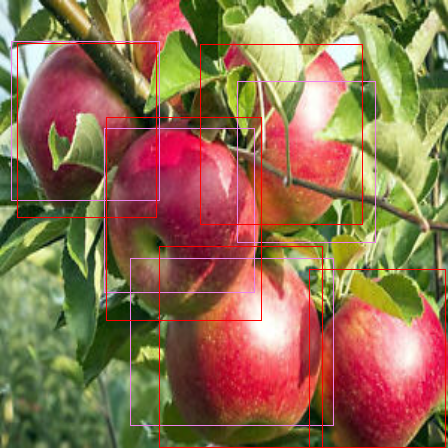

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 0)

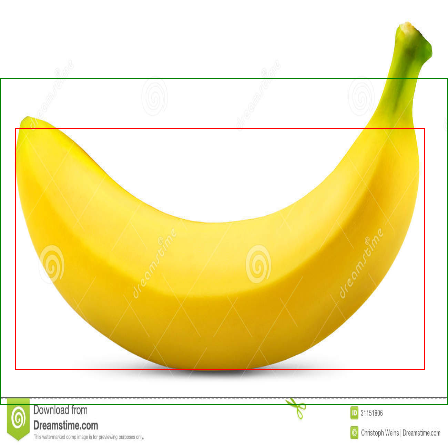

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 21)

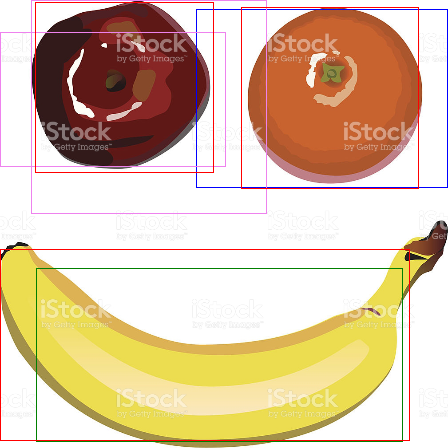

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 38)

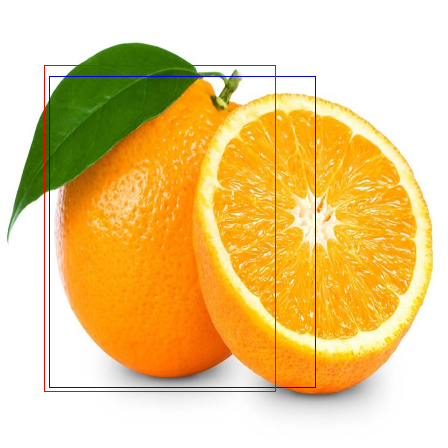

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 45)

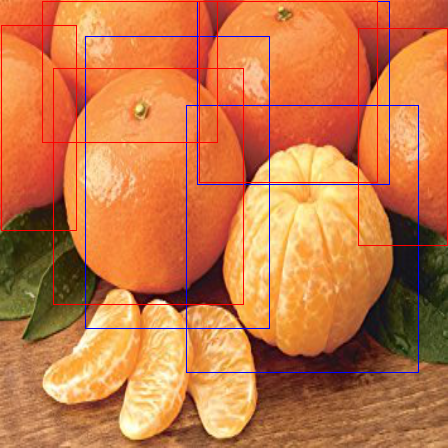

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 54)